<Body>   
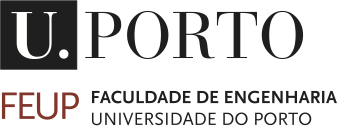   
<h1> <b>Computer Vision </b> </h1>
<p><b>Aiden Bugarín Carreira </b><br>
<b>Adrián Martínez Quivén </b>
</p>
<p>Master in Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# **Assignment 2: Captcha decoding**

# Part 1: Soft Dataset

## 0. Import packages

Fist, we import the packages we'll need and download the dataset.
This dataset contains 14860 CAPTCHA images divided in two groups: Soft and Hard.
The soft division contains the easiest images to decode, while the hard one contains more difficult images, which have strange elements and lines distorting the content. Each of this division has a Train and a Test folder with it's respective images.
Here we will be starting with the Soft Dataset

In [ ]:
import os
import cv2
import glob
import random
import gdown
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

!pip install torchinfo
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
file_id = "1NEZl9greFm9VpJ4HcXChssrnMz9dTEHs"
destination = "/content/CAPTCHA_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=True)

!unzip /content/CAPTCHA_dataset.zip -d /content/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/CAPTCHA_dataset/soft/train/34940.png  
  inflating: /content/CAPTCHA_dataset/soft/train/34hn.png  
  inflating: /content/CAPTCHA_dataset/soft/train/34i0.png  
  inflating: /content/CAPTCHA_dataset/soft/train/34tkf.png  
  inflating: /content/CAPTCHA_dataset/soft/train/35030.png  
  inflating: /content/CAPTCHA_dataset/soft/train/35105.png  
  inflating: /content/CAPTCHA_dataset/soft/train/35147.png  
  inflating: /content/CAPTCHA_dataset/soft/train/3515.png  
  inflating: /content/CAPTCHA_dataset/soft/train/35201.png  
  inflating: /content/CAPTCHA_dataset/soft/train/35219.png  
  inflating: /content/CAPTCHA_dataset/soft/train/35324.png  
  inflating: /content/CAPTCHA_dataset/soft/train/3533.png  
  inflating: /content/CAPTCHA_dataset/soft/train/3535.png  
  inflating: /content/CAPTCHA_dataset/soft/train/3538.png  
  inflating: /content/CAPTCHA_dataset/soft/train/3542.png  
  inflating: /content/CAPTCHA_d

## 1. Parameters

The first step is to definde the parameters we're going to use, like the size of the images, the path to the dataset, the batch size and the number of epochs. Then, we'll use the `define_charset()` function to define the character set. Since some of our images have 4 characters and others 5, we'll define a padding character _. Then, we'll define the character - index dictionary, where the first character is the padding and it has index 0, and the index increments until the last character in our character set.

In [ ]:
#images from the dataset dimensions
IMG_WIDTH = 200
IMG_HEIGHT  = 100

#paths to the dataset
train_dataset_path = 'CAPTCHA_dataset/soft/train/'
validate_dataset_path = 'CAPTCHA_dataset/soft/test/'

#parameters
batch = 10
num_epochs = 6

In [ ]:
def define_charset(image_dir):
    """
    Define the character set based on the file names in a directory.

    Args:
        image_dir (str): Path to the directory containing CAPTCHA images.

    Returns:
        str: A string of unique characters sorted in ascending order.
    """
    unique_chars = set()

    # Iterate through all files in the directory
    for filename in os.listdir(image_dir):
        # Extract the label from the filename (without extension)
        label = os.path.splitext(filename)[0]
        # Add each character in the label to the set
        unique_chars.update(label)

    # Convert set to a sorted string
    charset = ''.join(sorted(unique_chars))
    return charset


CHAR_SET = define_charset(train_dataset_path)
CHAR_SET = "_" + CHAR_SET
print("Character Set:", CHAR_SET)

#mappings
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHAR_SET)}
INDEX_TO_CHAR = {idx: char for idx, char in enumerate(CHAR_SET)}
PAD_IDX = CHAR_TO_INDEX["_"] # Padding index
print("Padding Index:", PAD_IDX)

Character Set: _0123456789abcdefghijklmnopqrstuvwxyz
Padding Index: 0


## 2. Preprocessing

Before creating our model, we'll apply preprocessing to the images. We'll use our `DetectCharacters` class to detect each character in the image, which we'll later use to train the model. We'll convert our images to grayscale, then detect and isolate each character each character and lastly we'll normalize each character tensor. After doing this, we need to prepare our data batch. We'll the `collate_fn()` function to add padding to ensure all our character and label batches are the same length.

In [ ]:
class DetectCharacters:
    def __init__(self, target_size=(28, 28), threshold_size=(4,3, 100, 150)):
        """
        Initialize the character detection transform.
        Args:
            target_size (tuple): The size to which each character image will be resized.
            threshold_size (tuple): (min_width, min_height, max_width, max_height)
                                    to filter valid character bounding boxes.
        """
        self.target_size = target_size
        self.min_width, self.min_height, self.max_width, self.max_height = threshold_size

    def __call__(self, img):
        """
        Detect and crop characters from the image.

        Args:
            img (PIL Image): The input image.

        Returns:
            list of torch.Tensor: A list of character images as tensors.
        """
        # convert PIL image to NumPy array
        img = np.array(img)

        #convert to grayscale
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #binary thresholding
        _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        #remove small noise
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        #erosion to separate connected components
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        cleaned = cv2.erode(cleaned, kernel, iterations=1)

        #find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        #extract bounding boxes and filter based on size
        bounding_boxes = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if self.min_width < w < self.max_width and self.min_height < h < self.max_height:
                bounding_boxes.append((x, y, w, h))

        # sort bounding boxes from left to right
        bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

        #crop characters and resize
        characters = []
        for (x, y, w, h) in bounding_boxes:
            char_img = binary[y:y+h, x:x+w]
            char_img = cv2.resize(char_img, self.target_size)
            char_tensor = F.to_tensor(char_img)  #convert to tensor
            characters.append(char_tensor)

        return characters

In [ ]:
class NormalizeCharacters:
    def __call__(self, characters):
        #normalize each character tensor
        normalized = [F.normalize(char, mean=[0.5], std=[0.5]) for char in characters]
        return normalized

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    DetectCharacters(target_size=(28, 28), threshold_size=(4, 13, 100, 150)),
    NormalizeCharacters()
])

In [ ]:
def collate_fn(batch):
    images_batch = []  #batches of character images
    labels_batch = []  #padded labels

    #determine the maximum sequence length for both characters and labels
    max_seq_len = max(max(len(characters), len(labels)) for characters, labels in batch)

    for characters, labels in batch:
        #pad character sequences with blank images
        padded_images = characters + [torch.zeros(1, 28, 28)] * (max_seq_len - len(characters))
        images_batch.append(torch.stack(padded_images))  # Stack into a sequence tensor

        #pad labels
        padded_label = torch.full((max_seq_len,), PAD_IDX, dtype=torch.long)
        padded_label[:len(labels)] = labels
        labels_batch.append(padded_label)

    #tensor for images (batch_size, seq_len, 1, height, width)
    images_batch = torch.stack(images_batch)
    labels_batch = torch.stack(labels_batch)

    return images_batch, labels_batch

## 3. Dataset class
Now, we're ready to create our dataset class. We'll use this class to load the dataset, transform it into tensors and preprocess it. We'll also extract and encode the labels as sequences of integers. After creating our `Dataset` instances, we'll create `Dataloader` instances and finally print the image and label batch shape so we can confirm it's working as intended.

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(self, image_folder_path, char_to_index, transform=None):
        self.image_folder_path = image_folder_path
        self.image_names = sorted(os.listdir(image_folder_path))
        self.char_to_index = char_to_index
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder_path, img_name)
        image = Image.open(img_path).convert("RGB")

        # transform image
        if self.transform:
            characters = self.transform(image)  #list of character tensors
        else:
            characters = [F.to_tensor(image)]  # fallback: one tensor for the whole image

        #labelremove extension
        label = os.path.splitext(img_name)[0]

        # label to sequence of integers
        label_encoded = [self.char_to_index[char] for char in label]

        return characters, torch.tensor(label_encoded, dtype=torch.long)

In [ ]:
#Create Dataset instances
train_dataset = CaptchaDataset(train_dataset_path, CHAR_TO_INDEX, transform=transform)
validate_dataset = CaptchaDataset(validate_dataset_path, CHAR_TO_INDEX, transform=transform)

#Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, collate_fn=collate_fn, drop_last=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch, shuffle=False, collate_fn=collate_fn)

#Access batches
for images, labels in train_loader:
    print("Batch of images shape:", images.shape) # images, 1 dimension (grayscale), IMG_HEIGHT , IMG_WIDTH
    print("Batch of labels:", labels) #the labels of the batch
    break

Batch of images shape: torch.Size([10, 5, 1, 28, 28])
Batch of labels: tensor([[ 1,  3,  7,  7,  4],
        [10,  8,  7,  8,  3],
        [ 9, 10,  2,  1,  0],
        [ 8,  4,  5,  9,  0],
        [ 3,  1,  1,  7,  0],
        [ 5,  5,  3,  6,  7],
        [ 7, 15, 16, 12, 29],
        [ 7,  4,  4,  8,  7],
        [ 3, 19, 13, 33, 15],
        [ 7,  5,  8,  2,  0]])


## 4. Visualization

Now, we'll visualize some images from the dataloader.

In [ ]:
def visualize_dataloader_batch(dataloader, num_samples=5):
    """
    Visualize a few samples from the DataLoader.

    Args:
        dataloader (DataLoader): The DataLoader instance.
        num_samples (int): Number of samples to visualize.
    """
    #one batch from the dataloader
    images_batch, labels_batch = next(iter(dataloader))

    #display
    for i in range(min(num_samples, len(images_batch))):
        fig, axes = plt.subplots(1, len(images_batch[i]), figsize=(15, 3))
        fig.suptitle(f"Label: {''.join([INDEX_TO_CHAR[idx.item()] for idx in labels_batch[i] if idx.item() != PAD_IDX])}", fontsize=16)

        #visualize each one
        for j, char_img in enumerate(images_batch[i]):
            char_img = char_img.squeeze().numpy()
            axes[j].imshow(char_img, cmap='gray')
            axes[j].axis('off')

        plt.show()

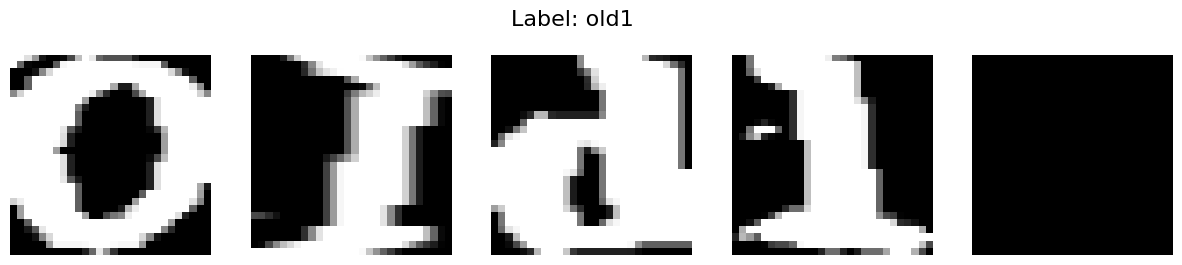

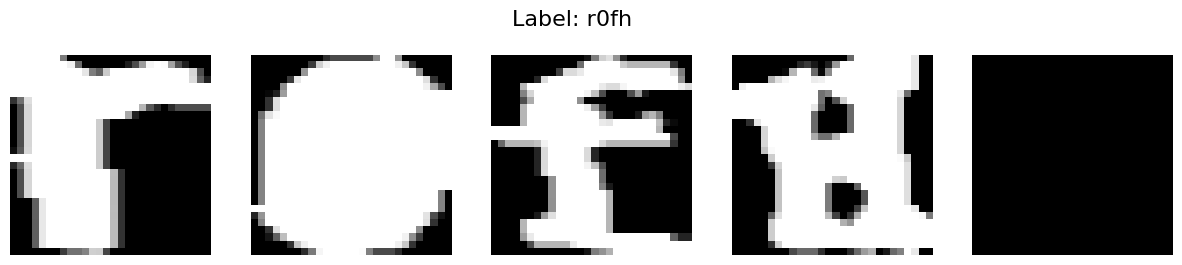

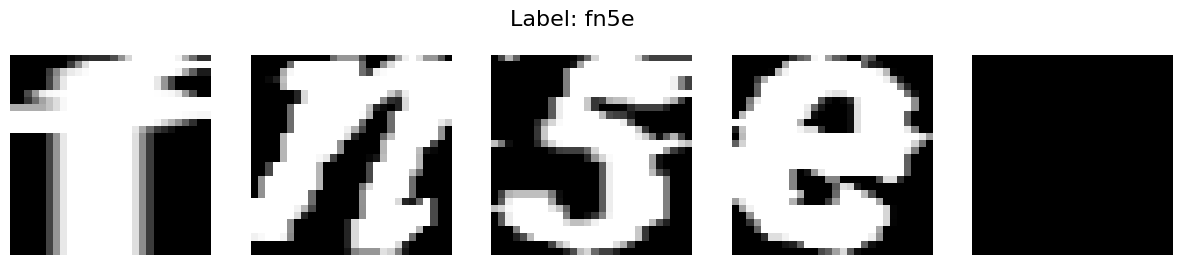

In [ ]:
visualize_dataloader_batch(train_loader, num_samples=3)

## 5. Model
Now, we can start developing our model. Our model uses convolutional neural networks (CNN) for feature extraction and bidirectional recurrent neural networks (RNN) for sequence modeling and to improve sequence understanding.

In [ ]:
class CNNRNNDecoder_soft(nn.Module):
    def __init__(self, char_set_size, cnn_out_channels=64, embedding_dim=128, hidden_dim=256, num_layers=2):
        super(CNNRNNDecoder_soft, self).__init__()

        # CNN for character feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  #downsample 1
            nn.Conv2d(cnn_out_channels, cnn_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  #downsample 2
        )

        # RNN for sequence modeling
        self.rnn = nn.LSTM(
            input_size=cnn_out_channels * 7 * 7,  # Flattened CNN output for input 28x28, as there are two downsamplings
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected layer for character classification
        self.fc = nn.Linear(hidden_dim * 2, char_set_size)  # Bidirectional doubles hidden size

    def forward(self, x):
        # Pass each character image through the CNN
        batch_size, seq_len, _, _, _ = x.size()
        x = x.view(batch_size * seq_len, 1, 28, 28)  # Flatten batch and sequence dimensions

        cnn_out = self.cnn(x)
        cnn_out = cnn_out.view(batch_size, seq_len, -1)  # Flatten CNN output for each character

        # Pass the sequence through the RNN
        rnn_out, _ = self.rnn(cnn_out)

        # Apply the fully connected layer to each timestep
        output = self.fc(rnn_out)
        return output

In [ ]:
# Number of unique characters (including padding "_")
char_set_size = len(CHAR_SET)

# Initialize the model
model = CNNRNNDecoder_soft(
    char_set_size=char_set_size,  # Number of characters in the CHAR_SET
    cnn_out_channels=64,         # Number of CNN output channels
    embedding_dim=128,           # Embedding dimension (optional, here for documentation)
    hidden_dim=256,              # RNN hidden dimension
    num_layers=2                 # Number of RNN layers
)

### 5.1. Loss function, optimizer and learning rate

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)  # Ignore padding tokens during loss calculation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 5.2. Training

Below is the function we'll use to train our model. This function, while training, will also print some useful data like the training loss, validation loss and validation accuracy. After the training process, we'll print and visualize the model predictions.

In [ ]:
def train_model(model, train_loader, validate_loader, criterion, optimizer, num_epochs,):
    """
    Train and validate the model.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        validate_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        num_epochs (int): Number of epochs to train for.
        device (str): Device to use for training (default: "cuda" if available).

    Returns:
        dict: Training and validation loss/accuracy per epoch.
    """
    # Move model to device
    model = model.to(device)

    # Store metrics for each epoch
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": []
    }

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-" * 20)

        model.train()  # Set model to training mode
        train_loss = 0.0

        for images, labels in tqdm(train_loader, desc="Training"):
            # data to device
            images = images.to(device)
            labels = labels.to(device)

            #forward pass
            outputs = model(images)  #(batch_size, seq_len, char_set_size)
            outputs = outputs.view(-1, outputs.size(-1))  # reshape for loss computation
            labels = labels.view(-1)  #flatten labels

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            train_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_loader)
        print(f"Training Loss: {avg_train_loss:.4f}")

        # Validation Phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_characters = 0
        total_characters = 0

        with torch.no_grad():  # No gradients needed for validation
            for images, labels in tqdm(validate_loader, desc="Validation"):
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)  # (batch_size, seq_len, char_set_size)
                outputs = outputs.view(-1, outputs.size(-1))  # Reshape for loss computation
                labels = labels.view(-1)  # Flatten labels

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                predictions = outputs.argmax(dim=1)  # Get predicted character indices
                correct_characters += (predictions == labels).sum().item()
                total_characters += labels.size(0)

        # Calculate average validation loss and accuracy
        avg_val_loss = val_loss / len(validate_loader)
        val_accuracy = correct_characters / total_characters
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.2%}")

        # Save metrics for this epoch
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_accuracy"].append(val_accuracy)

    return history

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
training = train_model(
    model=model,
    train_loader=train_loader,
    validate_loader=validate_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

#metrics
print("Training loss in each epoch",training["train_loss"])
print("Validation loss in each epoch",training["val_loss"])
print("Validatiopn accruacy in each epoch",training["val_accuracy"])

Epoch 1/6
--------------------


Training: 100%|██████████| 634/634 [00:27<00:00, 23.12it/s]


Training Loss: 0.9634


Validation: 100%|██████████| 144/144 [00:02<00:00, 56.95it/s]


Validation Loss: 0.4777
Validation Accuracy: 79.69%
Epoch 2/6
--------------------


Training: 100%|██████████| 634/634 [00:15<00:00, 39.85it/s]


Training Loss: 0.3796


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.33it/s]


Validation Loss: 0.3490
Validation Accuracy: 81.43%
Epoch 3/6
--------------------


Training: 100%|██████████| 634/634 [00:15<00:00, 40.02it/s]


Training Loss: 0.2497


Validation: 100%|██████████| 144/144 [00:02<00:00, 59.78it/s]


Validation Loss: 0.3317
Validation Accuracy: 81.88%
Epoch 4/6
--------------------


Training: 100%|██████████| 634/634 [00:15<00:00, 41.11it/s]


Training Loss: 0.1739


Validation: 100%|██████████| 144/144 [00:02<00:00, 51.53it/s]


Validation Loss: 0.3208
Validation Accuracy: 82.46%
Epoch 5/6
--------------------


Training: 100%|██████████| 634/634 [00:16<00:00, 39.37it/s]


Training Loss: 0.1155


Validation: 100%|██████████| 144/144 [00:02<00:00, 59.76it/s]


Validation Loss: 0.3360
Validation Accuracy: 82.32%
Epoch 6/6
--------------------


Training: 100%|██████████| 634/634 [00:15<00:00, 40.36it/s]


Training Loss: 0.0785


Validation: 100%|██████████| 144/144 [00:02<00:00, 58.64it/s]

Validation Loss: 0.3015
Validation Accuracy: 83.21%
Training loss in each epoch [0.9633738672249137, 0.379609376982395, 0.24973237280416588, 0.17388020770525858, 0.1155274761308202, 0.0784816832085359]
Validation loss in each epoch [0.4776916125168403, 0.34895599567486596, 0.3317391052001363, 0.32083062058275874, 0.33596953520100215, 0.3015288650896966]
Validatiopn accruacy in each epoch [0.7969401947148818, 0.8143254520166898, 0.8187760778859527, 0.8246175243393602, 0.8232267037552156, 0.8321279554937413]


In [ ]:
def print_predictions(model, dataloader, num_samples=5, device="cpu"):
    """
    Print the actual vs predicted labels for a few samples.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The DataLoader instance.
        num_samples (int): Number of samples to print.
        device (str): Device to perform computations on.
    """
    model.eval()  #model to evaluation mode
    samples_shown = 0

    with torch.no_grad():
        for images_batch, labels_batch in dataloader:
            # data to device
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            #model predictions
            outputs = model(images_batch)  # (batch_size, seq_len, char_set_size)
            predictions = outputs.argmax(dim=2)  # (batch_size, seq_len)

            for i in range(images_batch.size(0)):
                if samples_shown >= num_samples:
                    return

                #decode actual and predicted labels
                actual_label = "".join(
                    [INDEX_TO_CHAR[idx.item()] for idx in labels_batch[i] if idx.item() != PAD_IDX]
                )
                predicted_label = "".join(
                    [INDEX_TO_CHAR[idx.item()] for idx in predictions[i] if idx.item() != PAD_IDX]
                )

                #actual vs predicted
                print(f"Sample {samples_shown + 1}")
                print(f"  Actual:    {actual_label}")
                print(f"  Predicted: {predicted_label}")
                print("-" * 30)

                samples_shown += 1


In [ ]:
print_predictions(model, validate_loader, num_samples=10, device=device)

Sample 1
  Actual:    0009
  Predicted: 00060
------------------------------
Sample 2
  Actual:    00252
  Predicted: 00262
------------------------------
Sample 3
  Actual:    0049
  Predicted: 00499
------------------------------
Sample 4
  Actual:    0055
  Predicted: 00555
------------------------------
Sample 5
  Actual:    0058
  Predicted: 00588
------------------------------
Sample 6
  Actual:    0075
  Predicted: 00755
------------------------------
Sample 7
  Actual:    00773
  Predicted: 00773
------------------------------
Sample 8
  Actual:    0081
  Predicted: 00811
------------------------------
Sample 9
  Actual:    00816
  Predicted: 00816
------------------------------
Sample 10
  Actual:    00861
  Predicted: 00861
------------------------------


In [ ]:
def visualize_predictions(model, dataloader, num_samples=5, device="cpu"):
    """
    Visualize the actual vs predicted labels for a few samples.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The DataLoader instance.
        num_samples (int): Number of samples to visualize.
        device (str): Device to perform computations on.
    """
    model.eval()  #model to evaluation mode
    samples_shown = 0

    with torch.no_grad():
        for images_batch, labels_batch in dataloader:
            # data to device
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            #model predictions
            outputs = model(images_batch)  # (batch_size, seq_len, char_set_size)
            predictions = outputs.argmax(dim=2)  # (batch_size, seq_len)

            for i in range(images_batch.size(0)):
                if samples_shown >= num_samples:
                    return

                #decode actual and predicted labels
                actual_label = "".join(
                    [INDEX_TO_CHAR[idx.item()] for idx in labels_batch[i] if idx.item() != PAD_IDX]
                )
                predicted_label = "".join(
                    [INDEX_TO_CHAR[idx.item()] for idx in predictions[i] if idx.item() != PAD_IDX]
                )

                # Visualize the character images
                fig, axes = plt.subplots(1, len(images_batch[i]), figsize=(15, 3))
                fig.suptitle(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=16)

                for j, char_img in enumerate(images_batch[i]):
                    char_img = char_img.squeeze().cpu().numpy()  # Remove channel dimension and convert to NumPy array
                    axes[j].imshow(char_img, cmap='gray')
                    axes[j].axis('off')

                plt.show()
                samples_shown += 1

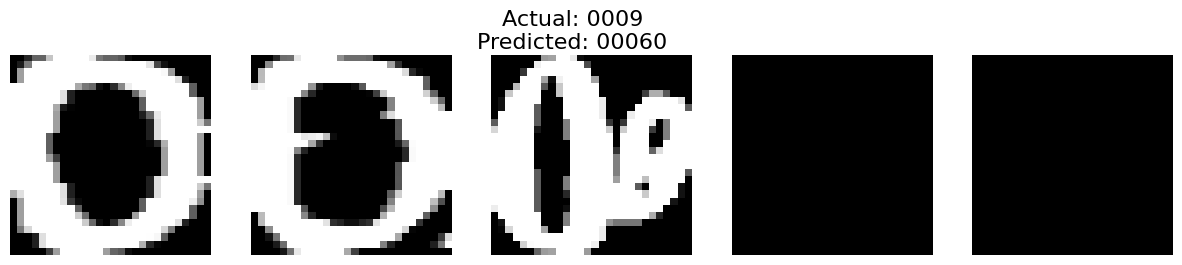

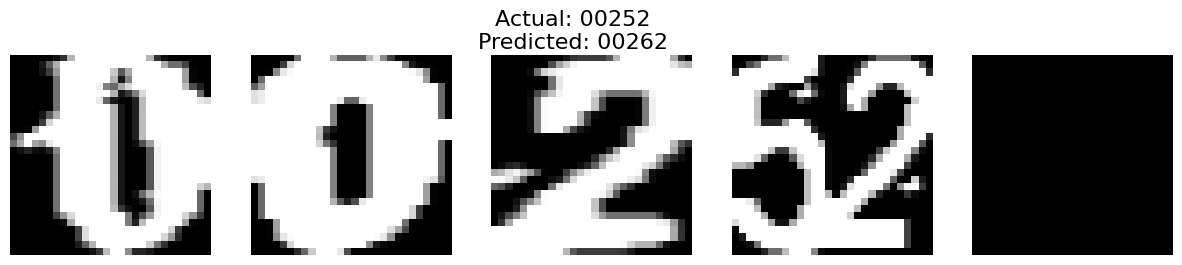

In [ ]:
visualize_predictions(model, validate_loader, num_samples=2, device=device)

## 6. Metrics

After our model is trained and validated, we'll add some metrics to assess its quality.

### 6.1. Accuracy

In [ ]:
def calculate_accuracy(dataloader, model, char_set_size):
    """
    Calculate accuracy for a given DataLoader and model.

    Args:
        dataloader (DataLoader): DataLoader for either train or test data.
        model (nn.Module): The trained model.
        char_set_size (int): Number of characters in the character set.

    Returns:
        float: Accuracy as a percentage.
    """
    model.eval()  #model to evaluation mode
    device = "cuda" if torch.cuda.is_available() else "cpu"

    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            # data to device
            images = images.to(device)
            labels = labels.to(device)

            #model predictions
            outputs = model(images)  # (batch_size, seq_len, char_set_size)
            predictions = outputs.argmax(dim=-1)  # Get predicted character indices

            #flatten
            true_labels = labels.view(-1).cpu().numpy()
            predicted_labels = predictions.view(-1).cpu().numpy()

            #ignore padding indices
            mask = true_labels != PAD_IDX
            all_true_labels.extend(true_labels[mask])
            all_predicted_labels.extend(predicted_labels[mask])

    # accuracy
    accuracy = accuracy_score(all_true_labels, all_predicted_labels) * 100
    return accuracy

In [ ]:
#Train and test accuracy
train_accuracy = calculate_accuracy(train_loader, model, char_set_size=len(CHAR_SET))
test_accuracy = calculate_accuracy(validate_loader, model, char_set_size=len(CHAR_SET))

#Results
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Train Accuracy: 98.82%
Test Accuracy: 92.80%


### 6.2. Confusion Matrix

In [ ]:
def evaluate_and_plot_confusion_matrix(model, validate_loader, device, PAD_IDX, CHAR_SET, INDEX_TO_CHAR):
    """
    Evaluate the model on the validation loader and plot a confusion matrix.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        validate_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        device (torch.device): The device to use for computation (CPU or GPU).
        PAD_IDX (int): The padding index in the labels.
        CHAR_SET (list): The character set used for prediction (all possible characters).
        INDEX_TO_CHAR (dict): Mapping from indices to characters for display.

    Returns:
        None
    """
    model.eval()  #model to evaluation mode
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for images, labels in validate_loader:
            images, labels = images.to(device), labels.to(device)

            # forward pass
            outputs = model(images)
            predictions = outputs.argmax(dim=-1)

            # flatten and filter out padding indices
            for batch_idx in range(labels.size(0)):  # Loop through the batch
                true = labels[batch_idx].tolist()
                pred = predictions[batch_idx].tolist()

                # remove padding tokens (PAD_IDX)
                true_filtered = [t for t in true if t != PAD_IDX]
                pred_filtered = [p for p in pred[:len(true_filtered)]]  # Match lengths of valid tokens

                # Debug to check per-batch lengths
                if len(true_filtered) != len(pred_filtered):
                    print(f"Length mismatch in batch {batch_idx}: {len(true_filtered)} true vs {len(pred_filtered)} predicted")

                all_true_labels.extend(true_filtered)
                all_predicted_labels.extend(pred_filtered)

    # Verify lengths before confusion matrix computation
    assert len(all_true_labels) == len(all_predicted_labels), \
        f"Mismatch: {len(all_true_labels)} true labels vs {len(all_predicted_labels)} predicted labels"

    # Generate the confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=range(len(CHAR_SET)))

    # Set up a larger figure size for better readability
    fig, ax = plt.subplots(figsize=(11, 11))

    # Display confusion matrix with larger labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[INDEX_TO_CHAR[idx] for idx in range(len(CHAR_SET))])
    disp.plot(cmap="viridis", ax=ax, xticks_rotation='vertical')

    # Customize font sizes for clarity
    ax.set_title("Confusion Matrix", fontsize=18)
    ax.set_xlabel("Predicted Labels", fontsize=14)
    ax.set_ylabel("True Labels", fontsize=14)
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)

    plt.show()


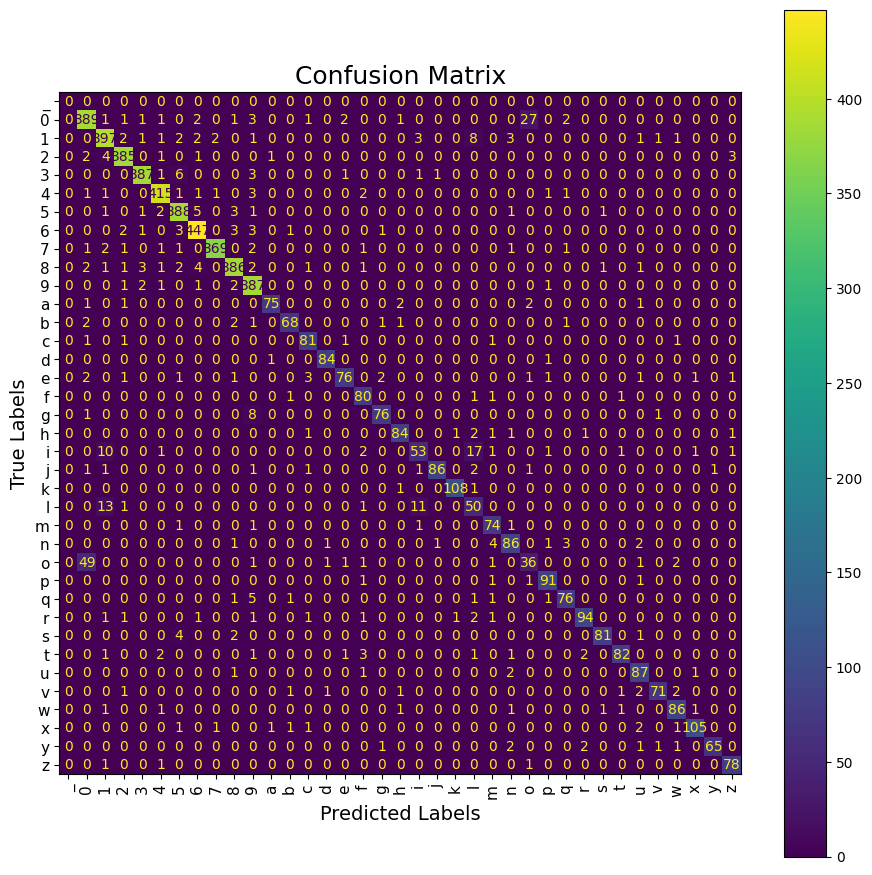

In [ ]:
evaluate_and_plot_confusion_matrix(
    model=model,
    validate_loader=validate_loader,
    device=device,
    PAD_IDX=PAD_IDX,
    CHAR_SET=CHAR_SET,
    INDEX_TO_CHAR=INDEX_TO_CHAR
)

We see in the confusion matrix some problems our model has. It often mistakes the letter "o" and the number 0 and the letters "i", "j" and "l". Below are the cases where the model was less accurate:

- too many times it mistook an "o" with a 0,
- some times it mistook a 0 with an "o".
- few times it mistook a 1 with an "l".
- some times it mistook an "i" with an "l", others with an "l", fewer times with a "t" and more times it correctly predicted "i".
- few times it mistook a "j" with an "i".
- few times it mistook an "l" with a 1.

### 6.3. Histogram of character predictions

In [ ]:
def plot_character_frequencies(all_true_labels, all_predicted_labels, CHAR_SET, INDEX_TO_CHAR):
    """
    Plot histograms comparing actual and predicted character frequencies.

    Args:
        all_true_labels (list): List of all true character labels.
        all_predicted_labels (list): List of all predicted character labels.
        CHAR_SET (list): The character set used for prediction (all possible characters).
        INDEX_TO_CHAR (dict): Mapping from indices to characters for display.

    Returns:
        None
    """
    #count the occurrences of each character in actual and predicted labels
    actual_counts = np.zeros(len(CHAR_SET), dtype=int)
    predicted_counts = np.zeros(len(CHAR_SET), dtype=int)

    for label in all_true_labels:
        actual_counts[label] += 1

    for label in all_predicted_labels:
        predicted_counts[label] += 1

    #define labels for the x-axis (characters)
    char_labels = [INDEX_TO_CHAR[idx] for idx in range(len(CHAR_SET))]

    # Plot the histograms side by side
    fig, ax = plt.subplots(figsize=(12, 7))

    x = np.arange(len(CHAR_SET))  # X-axis positions
    bar_width = 0.4  # Width of each bar

    # Actual character counts
    ax.bar(x - bar_width / 2, actual_counts, width=bar_width, label="Actual Characters", color="skyblue")

    # Predicted character counts
    ax.bar(x + bar_width / 2, predicted_counts, width=bar_width, label="Predicted Characters", color="orange")

    # Add titles and labels
    ax.set_title("Histogram of Predicted Characters vs. Actual Characters", fontsize=18)
    ax.set_xlabel("Characters", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(char_labels, fontsize=12, rotation=90)  # Rotate for better visibility
    ax.legend(fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for images, labels in validate_loader:
        images, labels = images.to(device), labels.to(device)

        #foreward pass
        outputs = model(images)
        predictions = outputs.argmax(dim=-1)

        #flatten and filter out padding indices
        for batch_idx in range(labels.size(0)):  # Loop through the batch
            true = labels[batch_idx].tolist()
            pred = predictions[batch_idx].tolist()

            # Remove padding tokens (PAD_IDX)
            true_filtered = [t for t in true if t != PAD_IDX]
            pred_filtered = [p for p in pred[:len(true_filtered)]]  # Match lengths of valid tokens

            # check per-batch lengths
            if len(true_filtered) != len(pred_filtered):
                print(f"Length mismatch in batch {batch_idx}: {len(true_filtered)} true vs {len(pred_filtered)} predicted")

            all_true_labels.extend(true_filtered)
            all_predicted_labels.extend(pred_filtered)

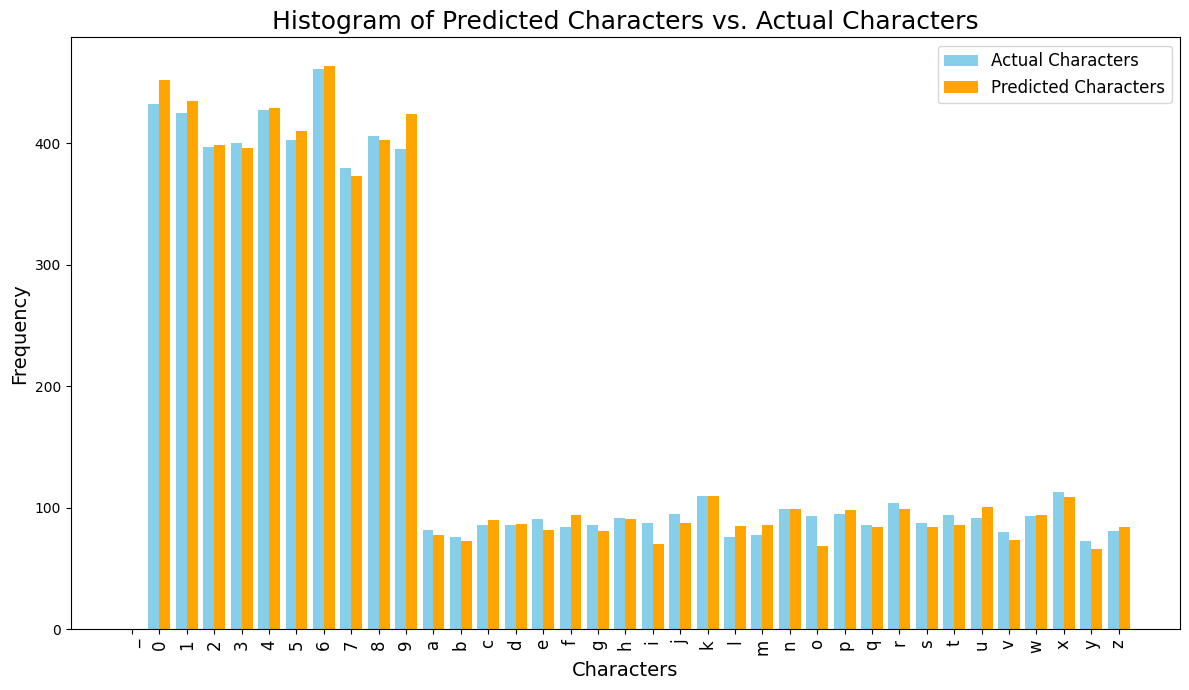

In [ ]:
plot_character_frequencies(
    all_true_labels=all_true_labels,
    all_predicted_labels=all_predicted_labels,
    CHAR_SET=CHAR_SET,
    INDEX_TO_CHAR=INDEX_TO_CHAR
)

We can see that the numbers were more common than the letters, since there are only 10 numbers but 26 letters. In the histogram we can also see that the most mistaken characters in the prediction were the 0, 1, "l" and "o".

### 6.4. Per-Character Accuracy

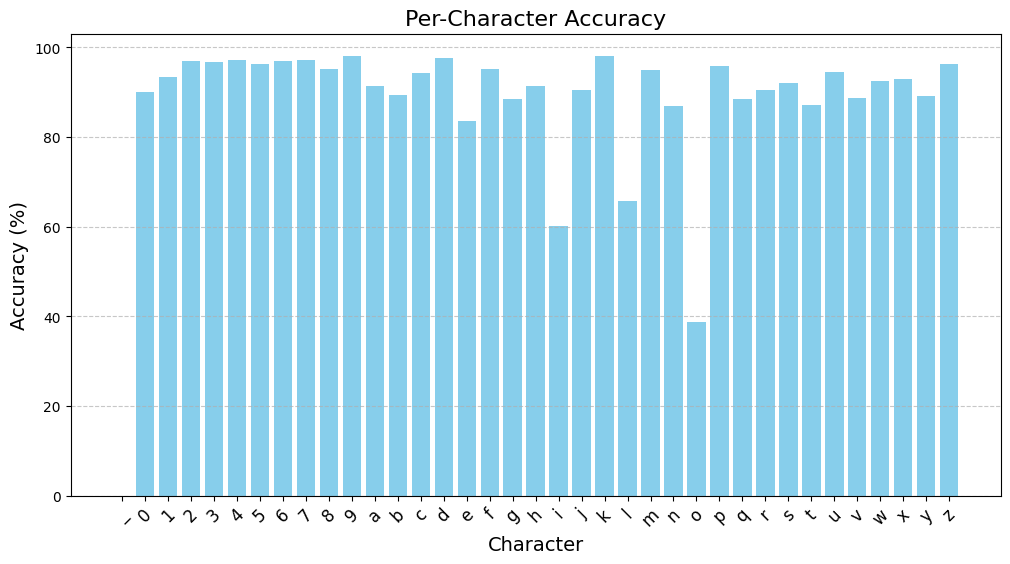

In [ ]:
#Per-Character Accuracy
char_accuracy = {}
for idx, char in enumerate(CHAR_SET):
    true_count = sum((true == pred) and (true == idx) for true, pred in zip(all_true_labels, all_predicted_labels))
    total_count = sum(true == idx for true in all_true_labels)
    char_accuracy[char] = (true_count / total_count * 100) if total_count > 0 else 0.0

plt.figure(figsize=(12, 6))
plt.bar(char_accuracy.keys(), char_accuracy.values(), color='skyblue')
plt.xlabel("Character", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("Per-Character Accuracy", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This graph further consolidates the fact that the model's main inaccuracy source is the letter "o".

### 6.5. Model complexity

Below is the model complexity analysis.

In [ ]:
#Calculate trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

Total Trainable Parameters: 8,584,421


In [ ]:
#Model complexity analysis
summary(
    model,
    input_size=(batch, 5, 1, 28, 28),  # Adjust based on your input dimensions
    col_names=["input_size", "output_size", "num_params", "mult_adds"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Mult-Adds
CNNRNNDecoder_soft (CNNRNNDecoder_soft)  [10, 5, 1, 28, 28]   [10, 5, 37]          --                   --
├─Sequential (cnn)                       [50, 1, 28, 28]      [50, 64, 7, 7]       --                   --
│    └─Conv2d (0)                        [50, 1, 28, 28]      [50, 64, 28, 28]     640                  25,088,000
│    └─ReLU (1)                          [50, 64, 28, 28]     [50, 64, 28, 28]     --                   --
│    └─MaxPool2d (2)                     [50, 64, 28, 28]     [50, 64, 14, 14]     --                   --
│    └─Conv2d (3)                        [50, 64, 14, 14]     [50, 64, 14, 14]     36,928               361,894,400
│    └─ReLU (4)                          [50, 64, 14, 14]     [50, 64, 14, 14]     --                   --
│    └─MaxPool2d (5)                     [50, 64, 14, 14]     [50, 64, 7, 7]       --                   --
├─LSTM (rnn) 

### 6.6. Precision, Recall, F1-Score (Per-Class and Overall)

In [ ]:
CHAR_SET_no_pad = [char for char in CHAR_SET if char != '_'] #remodve the padding index ('-')
CHAR_SET_list = list(CHAR_SET_no_pad)
classification_metrics = classification_report(
    all_true_labels,
    all_predicted_labels,
    target_names=CHAR_SET_list,
    digits=4
)
print("Classification Report (Precision, Recall, F1-Score):")
print(classification_metrics)

# Precision, Recall, F1-Score overall
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1:.4f}")

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

           0     0.8606    0.9005    0.8801       432
           1     0.9126    0.9341    0.9233       425
           2     0.9649    0.9698    0.9673       397
           3     0.9773    0.9675    0.9724       400
           4     0.9674    0.9719    0.9696       427
           5     0.9463    0.9628    0.9545       403
           6     0.9634    0.9696    0.9665       461
           7     0.9893    0.9711    0.9801       380
           8     0.9578    0.9507    0.9543       406
           9     0.9127    0.9797    0.9451       395
           a     0.9615    0.9146    0.9375        82
           b     0.9315    0.8947    0.9128        76
           c     0.9000    0.9419    0.9205        86
           d     0.9655    0.9767    0.9711        86
           e     0.9268    0.8352    0.8786        91
           f     0.8511    0.9524    0.8989        84
           g     0.9383    0

### 6.7. Character Position Error (CPE)

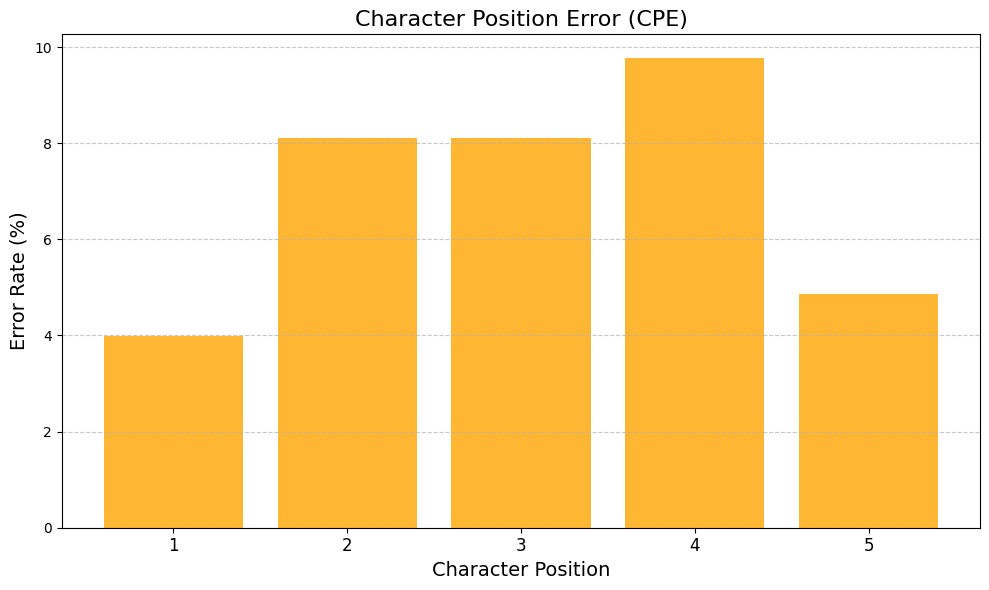

In [ ]:
def calculate_cpe(dataloader, model, seq_length, char_set_size, pad_idx=PAD_IDX):
    """
    Calculate Character Position Error (CPE) for a given dataloader and model.

    Args:
        dataloader (DataLoader): DataLoader for evaluation (e.g., train or validation set).
        model (nn.Module): Trained model.
        seq_length (int): Maximum sequence length of the CAPTCHA.
        char_set_size (int): Number of characters in the character set.
        pad_idx (int): Padding index in the labels.

    Returns:
        list: CPE for each character position as a percentage.
    """
    model.eval()  #model to evaluation mode
    device = "cuda" if torch.cuda.is_available() else "cpu"
    position_errors = np.zeros(seq_length, dtype=int)  #Error count for each position
    position_totals = np.zeros(seq_length, dtype=int)  #Total count for each position

    with torch.no_grad():
        for images, labels in dataloader:
            #move to device
            images = images.to(device)
            labels = labels.to(device)

            #foreward pass and predictions
            outputs = model(images)  # (batch_size, seq_length, char_set_size)
            predictions = outputs.argmax(dim=-1)  # predicted character indices

            for batch_idx in range(labels.size(0)):  # Iterate over batch
                true_seq = labels[batch_idx].tolist()  # True sequence
                pred_seq = predictions[batch_idx].tolist()  # Predicted sequence

                for pos in range(seq_length):
                    if true_seq[pos] != pad_idx:  # Ignore padding indices
                        position_totals[pos] += 1
                        if true_seq[pos] != pred_seq[pos]:
                            position_errors[pos] += 1

    # Calculate CPE as a percentage for each position
    cpe = (position_errors / position_totals) * 100
    return cpe

# Compute CPE for validation data
seq_length = 5  # Example: Maximum sequence length of CAPTCHA
cpe = calculate_cpe(validate_loader, model, seq_length, char_set_size=len(CHAR_SET))

# Plot CPE as a bar chart
plt.figure(figsize=(10, 6))
positions = np.arange(1, seq_length + 1)
plt.bar(positions, cpe, color="orange", alpha=0.8)

# Add labels and titles
plt.xlabel("Character Position", fontsize=14)
plt.ylabel("Error Rate (%)", fontsize=14)
plt.title("Character Position Error (CPE)", fontsize=16)
plt.xticks(positions, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

### 6.8. Confidence per character Distribution

In [ ]:
def calculate_confidence_per_character(dataloader, model):
    """
    Calculate and visualize confidence per character in the dataset.

    Args:
        dataloader (DataLoader): DataLoader for evaluation.
        model (nn.Module): Trained model.

    Returns:
        dict: Average confidence per character.
    """
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    character_confidences = {char: [] for char in CHAR_SET}  # Initialize dictionary for confidences

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)  # (batch_size, seq_len, char_set_size)
            probabilities = torch.softmax(outputs, dim=-1)  # Convert logits to probabilities
            max_probs, predictions = probabilities.max(dim=-1)  # Get max confidence and predicted class

            for batch_idx in range(labels.size(0)):
                true_seq = labels[batch_idx].tolist()
                max_probs_seq = max_probs[batch_idx].tolist()

                for idx, (true_idx, confidence) in enumerate(zip(true_seq, max_probs_seq)):
                    if true_idx != PAD_IDX:  # Skip padding tokens
                        char = INDEX_TO_CHAR[true_idx]
                        character_confidences[char].append(confidence)

    # Calculate average confidence for each character
    average_confidences = {
        char: ((sum(confidences) / len(confidences)) * 100) if confidences else 0.0
        for char, confidences in character_confidences.items()
    }

    # Visualize average confidence per character
    plt.figure(figsize=(12, 6))
    plt.bar(average_confidences.keys(), average_confidences.values(), color="skyblue")
    plt.xlabel("Character", fontsize=14)
    plt.ylabel("Average Confidence (%)", fontsize=14)
    plt.title("Average Confidence Per Character", fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    return average_confidences

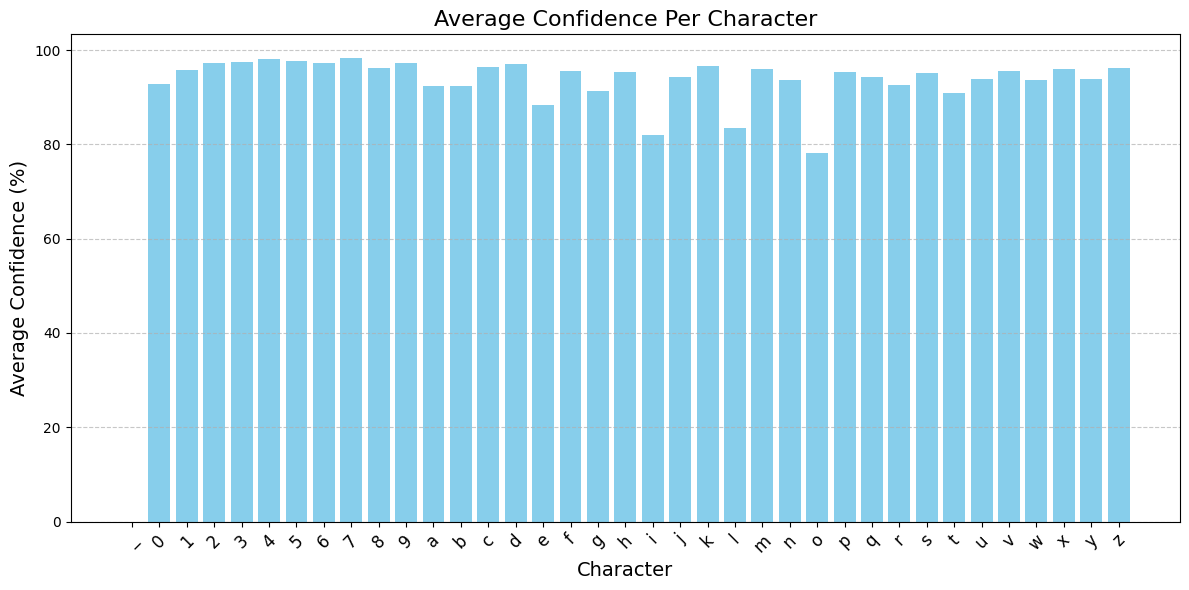

In [ ]:
#Visualize confidence per character
confidence_per_character = calculate_confidence_per_character(validate_loader, model)

## 7. Limitations

As we saw in the metrics part, this model has several limitations. The first one is its reliance on character detection. If the character detection is not working correctly, the model struggles to correctly predict each character. It also has problems differenciating similar characters like 0 and "o", or "i", "l", "j" and 1.

---

# Part 2: Hard Dataset

Now, we'll repeat the same process as before but with the hard dataset. The model remains the same as before, but the character detection functions have been refined for this dataset since it contains additional lines and general noise than the soft dataset doesn't have.

## 1. Parameters

In [ ]:
#paths to the dataset
train_dataset_path = 'CAPTCHA_dataset/hard/train/'
validate_dataset_path = 'CAPTCHA_dataset/hard/test/'

#parameters
batch = 10
num_epochs = 8

In [ ]:
CHAR_SET = define_charset(train_dataset_path)
CHAR_SET = "_" + CHAR_SET
print("Character Set:", CHAR_SET)

#mappings
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHAR_SET)}
INDEX_TO_CHAR = {idx: char for idx, char in enumerate(CHAR_SET)}
PAD_IDX = CHAR_TO_INDEX["_"] # Padding index
print("Padding Index:", PAD_IDX)

Character Set: _0123456789abcdefghijklmnopqrstuvwxyz
Padding Index: 0


## 2. Preprocessing

In [ ]:
class DetectCharacters:
    def __init__(self, target_size=(28, 28), threshold_size=(4, 3, 100, 150)):
        """
        Initialize the character detection transform.

        Args:
            target_size (tuple): The size to which each character image will be resized.
            threshold_size (tuple): (min_width, min_height, max_width, max_height)
                                    to filter valid character bounding boxes.
        """
        self.target_size = target_size
        self.min_width, self.min_height, self.max_width, self.max_height = threshold_size

    def remove_lines(self, binary_img):
        """
        Remove lines from the binary image.
        """
        # horizontal kernel to detect horizontal lines
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
        detected_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
        # subtract lines from binary image
        no_lines = cv2.subtract(binary_img, detected_lines)
        return no_lines

    def __call__(self, img):
        """
        Detect and crop characters from the image.

        Args:
            img (PIL Image): The input image.

        Returns:
            list of torch.Tensor: A list of character images as tensors.
        """
        # convert PIL image to NumPy array
        img = np.array(img)

        # convert to grayscale
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Gaussian Blur
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # adaptive thresholding
        binary = cv2.adaptiveThreshold(
            img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
        )

        # remove lines
        binary = self.remove_lines(binary)

        #remove small noise with morphological opening
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        #find contours
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # extract bounding boxes and filter based on size
        bounding_boxes = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if self.min_width < w < self.max_width and self.min_height < h < self.max_height:
                bounding_boxes.append((x, y, w, h))

        #sort bounding boxes
        bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

        #crop and resize
        characters = []
        for (x, y, w, h) in bounding_boxes:
            char_img = cleaned[y:y+h, x:x+w]
            char_img = cv2.resize(char_img, self.target_size)
            char_tensor = F.to_tensor(char_img)  # Convert to tensor
            characters.append(char_tensor)

        return characters

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    DetectCharacters(target_size=(28, 28), threshold_size=(6, 30, 200, 200)),
    NormalizeCharacters()
])

In [ ]:
#Create Dataset instances
train_dataset = CaptchaDataset(train_dataset_path, CHAR_TO_INDEX, transform=transform)
validate_dataset = CaptchaDataset(validate_dataset_path, CHAR_TO_INDEX, transform=transform)

#Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, collate_fn=collate_fn, drop_last=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch, shuffle=False, collate_fn=collate_fn)

#Access batches
for images, labels in train_loader:
    print("Batch of images shape:", images.shape) #32 images, 1 dimension (grayscale), IMG_HEIGHT , IMG_WIDTH
    print("Batch of labels:", labels) #the 32 labels of the batch
    break

Batch of images shape: torch.Size([10, 5, 1, 28, 28])
Batch of labels: tensor([[ 6,  4,  6,  1,  0],
        [ 5,  4,  3,  3,  0],
        [10,  2,  5,  5,  6],
        [36,  1, 22, 11,  0],
        [ 5,  6,  8,  8,  3],
        [ 3, 32, 21, 16,  0],
        [ 6,  7,  7,  6,  0],
        [ 4,  9,  6,  2,  0],
        [10,  3,  2,  8,  4],
        [13, 30, 21, 34, 21]])


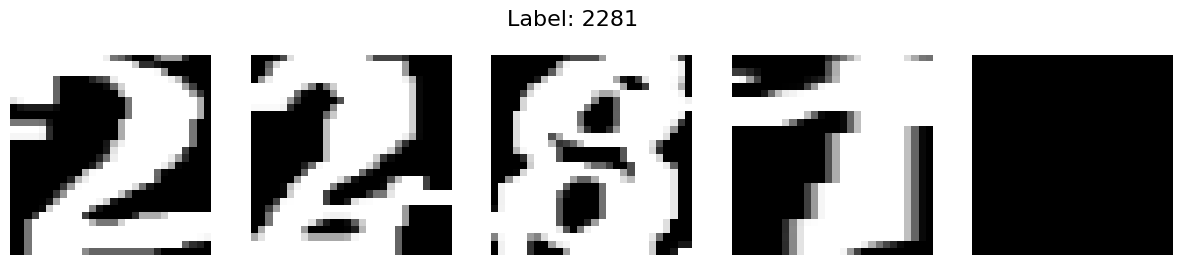

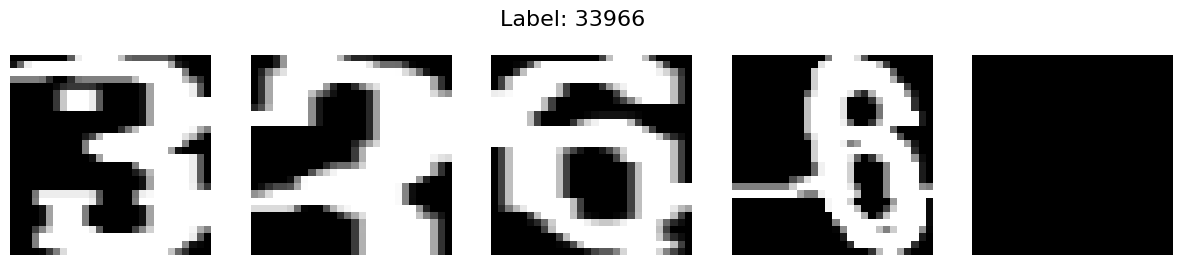

In [ ]:
visualize_dataloader_batch(train_loader, num_samples=2)

## 3. Model

In [ ]:
class CNNRNNDecoder_hard(nn.Module):
    def __init__(self, char_set_size, cnn_out_channels=64, embedding_dim=128, hidden_dim=256, num_layers=2):
        super(CNNRNNDecoder_hard, self).__init__()

        #CNN for character feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  #Downsample 1
            nn.Conv2d(cnn_out_channels, cnn_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  #Downsample 2
            nn.Dropout(0.2)  #Dropout layer
        )

        #RNN for sequence modeling
        self.rnn = nn.LSTM(
            input_size=cnn_out_channels * 7 * 7,  #Flattened CNN output for input 28x28, after two downsamplings
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2  #Dropout between LSTM layers
        )

        #Fully connected layer for character classification
        self.fc = nn.Sequential(
            nn.Dropout(0.2),  #Dropout before the FC layer
            nn.Linear(hidden_dim * 2, char_set_size)  #Bidirectional doubles hidden size
        )

    def forward(self, x):
        #Pass character images through the CNN
        batch_size, seq_len, _, _, _ = x.size()
        x = x.view(batch_size * seq_len, 1, 28, 28)  #Flatten batch and sequence dimensions

        cnn_out = self.cnn(x)
        cnn_out = cnn_out.view(batch_size, seq_len, -1)  #Flatten CNN output for each character

        #Pass the sequence through the RNN
        rnn_out, _ = self.rnn(cnn_out)

        #Fully connected layer to each timestep
        output = self.fc(rnn_out)
        return output

In [ ]:
model = CNNRNNDecoder_hard(
    char_set_size=char_set_size,  # Number of characters in the CHAR_SET
    cnn_out_channels=64,         # Number of CNN output channels
    embedding_dim=128,           # Embedding dimension (optional; here for documentation)
    hidden_dim=256,              # RNN hidden dimension
    num_layers=2                 # Number of RNN layers
)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)  #Ignore padding tokens during loss calculation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 3.1. Training

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
training = train_model(
    model=model,
    train_loader=train_loader,
    validate_loader=validate_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

#metrics
print("Training loss in each epoch",training["train_loss"])
print("Validation loss in each epoch",training["val_loss"])
print("Validatiopn accruacy in each epoch",training["val_accuracy"])

Epoch 1/8
--------------------


Training: 100%|██████████| 565/565 [00:16<00:00, 33.67it/s]


Training Loss: 2.0619


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.56it/s]


Validation Loss: 1.4664
Validation Accuracy: 55.90%
Epoch 2/8
--------------------


Training: 100%|██████████| 565/565 [00:17<00:00, 33.02it/s]


Training Loss: 1.3642


Validation: 100%|██████████| 144/144 [00:03<00:00, 39.48it/s]


Validation Loss: 1.3048
Validation Accuracy: 58.80%
Epoch 3/8
--------------------


Training: 100%|██████████| 565/565 [00:16<00:00, 33.97it/s]


Training Loss: 1.1915


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.11it/s]


Validation Loss: 1.2615
Validation Accuracy: 60.04%
Epoch 4/8
--------------------


Training: 100%|██████████| 565/565 [00:17<00:00, 32.09it/s]


Training Loss: 1.0783


Validation: 100%|██████████| 144/144 [00:03<00:00, 42.10it/s]


Validation Loss: 1.2230
Validation Accuracy: 60.23%
Epoch 5/8
--------------------


Training: 100%|██████████| 565/565 [00:16<00:00, 33.78it/s]


Training Loss: 0.9693


Validation: 100%|██████████| 144/144 [00:03<00:00, 43.00it/s]


Validation Loss: 1.2236
Validation Accuracy: 60.67%
Epoch 6/8
--------------------


Training: 100%|██████████| 565/565 [00:17<00:00, 32.42it/s]


Training Loss: 0.8717


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.15it/s]


Validation Loss: 1.2413
Validation Accuracy: 60.81%
Epoch 7/8
--------------------


Training: 100%|██████████| 565/565 [00:16<00:00, 33.90it/s]


Training Loss: 0.7664


Validation: 100%|██████████| 144/144 [00:03<00:00, 38.76it/s]


Validation Loss: 1.2700
Validation Accuracy: 60.48%
Epoch 8/8
--------------------


Training: 100%|██████████| 565/565 [00:16<00:00, 33.24it/s]


Training Loss: 0.6560


Validation: 100%|██████████| 144/144 [00:03<00:00, 47.33it/s]

Validation Loss: 1.3050
Validation Accuracy: 60.63%
Training loss in each epoch [2.061945484802786, 1.364245244465043, 1.1915397085974702, 1.078260099676858, 0.96926108308598, 0.8717281273508494, 0.7663908955533948, 0.6559938532984362]
Validation loss in each epoch [1.4663558697534933, 1.3047835752367973, 1.2614736974032388, 1.2229738020234637, 1.2236231901786394, 1.2413462510125504, 1.2700367179802723, 1.3049655807101064]
Validatiopn accruacy in each epoch [0.5590153027278776, 0.5880239520958084, 0.6003992015968064, 0.6022621423819029, 0.6066533599467732, 0.6081170991350632, 0.6047904191616766, 0.6062541583499668]


## 4. Metrics

### 4.1. Accuracy

In [ ]:
#Compute train and test accuracy
train_accuracy = calculate_accuracy(train_loader, model, char_set_size=len(CHAR_SET))
test_accuracy = calculate_accuracy(validate_loader, model, char_set_size=len(CHAR_SET))

#Display results
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Train Accuracy: 87.16%
Test Accuracy: 70.62%


### 4.2. Confusion Matrix

In [ ]:
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for images, labels in validate_loader:
        images, labels = images.to(device), labels.to(device)

        #forward pass
        outputs = model(images)
        predictions = outputs.argmax(dim=-1)

        # flatten and filter out padding indices
        for batch_idx in range(labels.size(0)):  # Loop through the batch
            true = labels[batch_idx].tolist()
            pred = predictions[batch_idx].tolist()

            # remove padding tokens (PAD_IDX)
            true_filtered = [t for t in true if t != PAD_IDX]
            pred_filtered = [p for p in pred[:len(true_filtered)]]

            # Debug to check per-batch lengths
            if len(true_filtered) != len(pred_filtered):
                print(f"Length mismatch in batch {batch_idx}: {len(true_filtered)} true vs {len(pred_filtered)} predicted")

            all_true_labels.extend(true_filtered)
            all_predicted_labels.extend(pred_filtered)

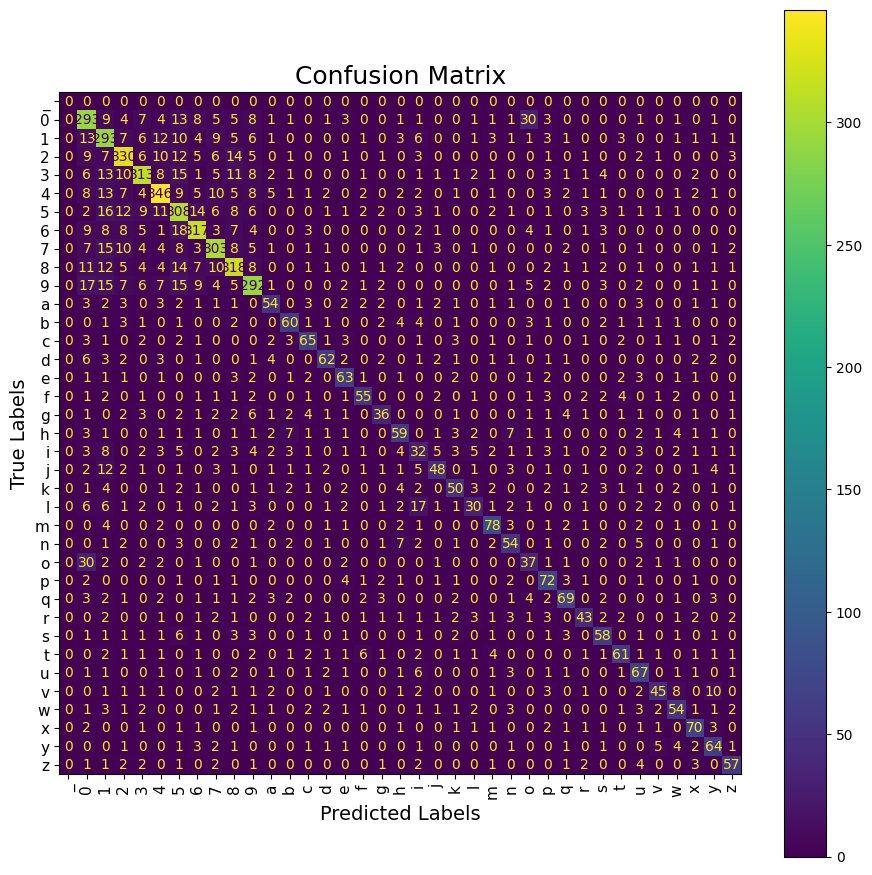

In [ ]:
evaluate_and_plot_confusion_matrix(
    model=model,
    validate_loader=validate_loader,
    device=device,
    PAD_IDX=PAD_IDX,
    CHAR_SET=CHAR_SET,
    INDEX_TO_CHAR=INDEX_TO_CHAR
)

### 4.3. Histogram of character predictions

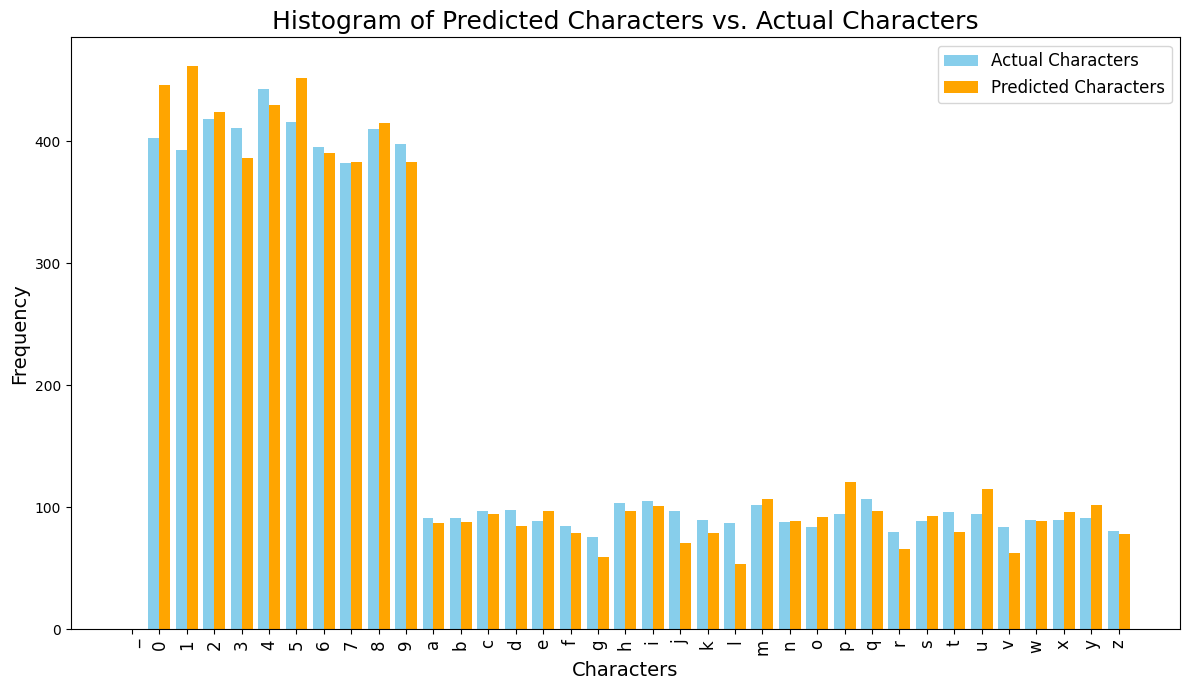

In [ ]:
plot_character_frequencies(
    all_true_labels=all_true_labels,
    all_predicted_labels=all_predicted_labels,
    CHAR_SET=CHAR_SET,
    INDEX_TO_CHAR=INDEX_TO_CHAR
)

### 4.4. Per-character accuracy

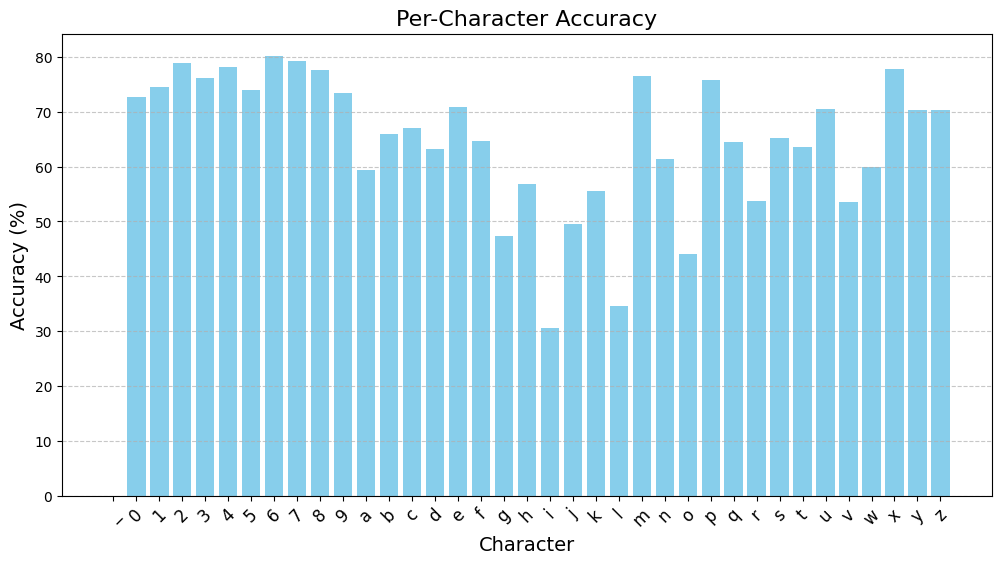

In [ ]:
#Per-Character Accuracy
char_accuracy = {}
for idx, char in enumerate(CHAR_SET):
    true_count = sum((true == pred) and (true == idx) for true, pred in zip(all_true_labels, all_predicted_labels))
    total_count = sum(true == idx for true in all_true_labels)
    char_accuracy[char] = (true_count / total_count * 100) if total_count > 0 else 0.0

plt.figure(figsize=(12, 6))
plt.bar(char_accuracy.keys(), char_accuracy.values(), color='skyblue')
plt.xlabel("Character", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("Per-Character Accuracy", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4.5. Confidence per character

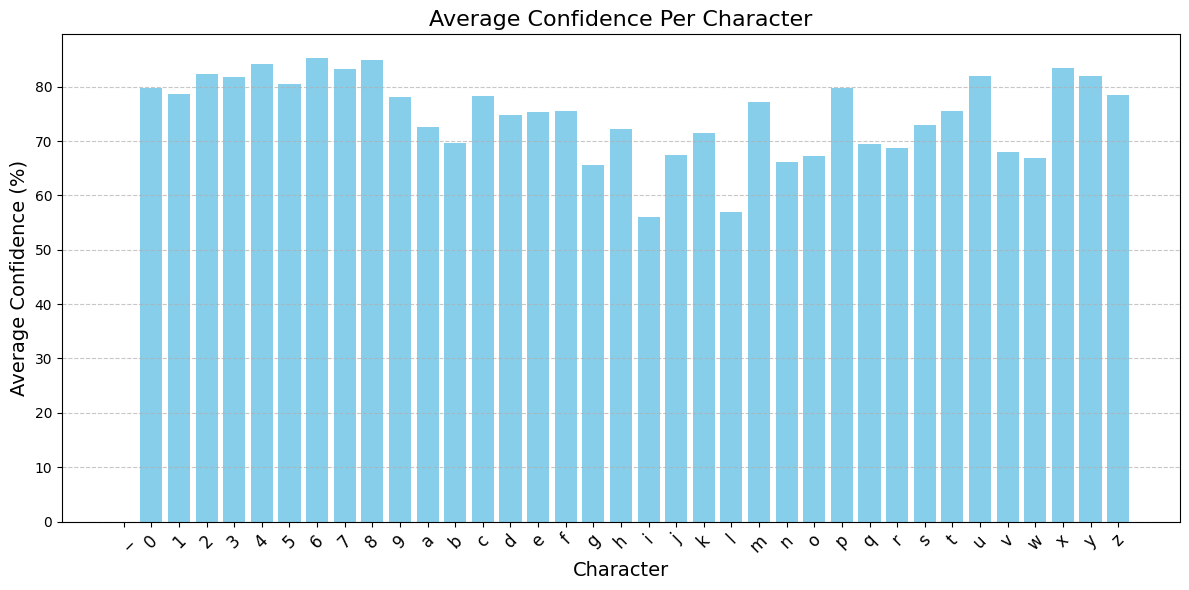

In [ ]:
#Visualize confidence per character
confidence_per_character = calculate_confidence_per_character(validate_loader, model)

As we can see in all these metrics, when using the hard dataset the model presents the same problems as before, but they appear incremented. It struggles more to identify the "i" than with the soft dataset, but overall the limitations remain the same, and the model generally makes more mistakes. The fact that the letter "i" is harder to detect in the hard dataset might also be due to the character separations, that doesn't correctly detect this letter.